In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier

import cv2
import joblib 
from scipy.ndimage import center_of_mass

# Downloading the data and inspecting it

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)

X = mnist["data"]
y = mnist["target"].astype(np.uint8)

C:\Users\46704\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
print("There are {} examples .".format(X.shape[0]))

There are 70000 examples .


In [4]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=10000, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=42)

In [5]:
# number of classes and unique classes
print("The model consists of {} classes. They are labeled as:\n".format(len(np.unique(y_train))))
print(np.unique(y_train))

The model consists of 10 classes. They are labeled as:

[0 1 2 3 4 5 6 7 8 9]


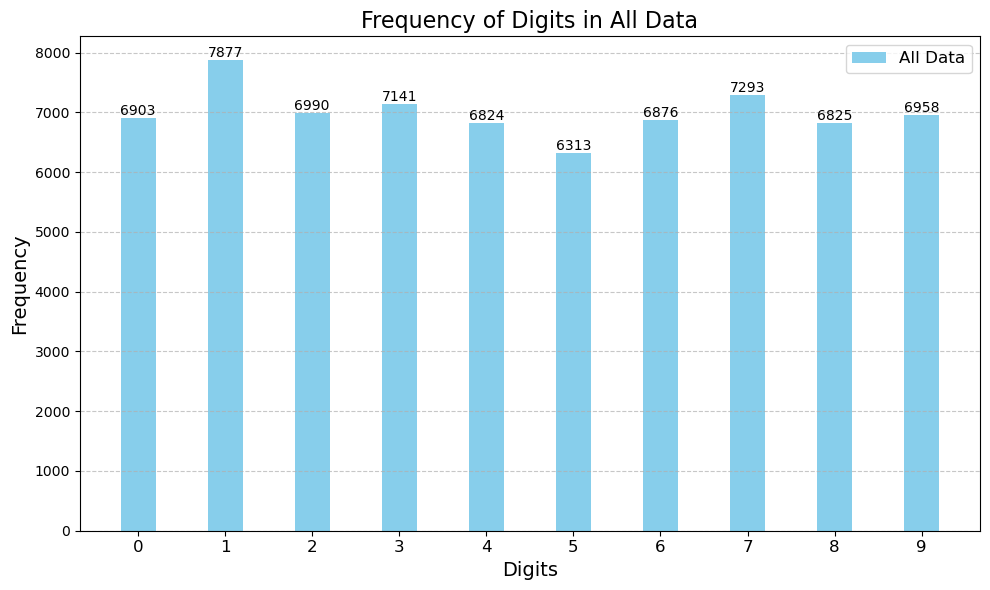

In [6]:
all_digit_counts = np.bincount(y)

# Plot a bar chart for all data
plt.figure(figsize=(10, 6))

# All data combined
plt.bar(np.arange(10), all_digit_counts, width=0.4, color='skyblue', label='All Data')

plt.title('Frequency of Digits in All Data', fontsize=16)
plt.xlabel('Digits', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(np.arange(10), np.arange(10), fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

# Add values on top of each bar
for i, freq in enumerate(all_digit_counts):
    plt.text(i, freq, str(freq), fontsize=10, ha='center', va='bottom', color='black')

plt.tight_layout()
plt.show()

In [7]:
# list class distributions
print('Class distribution in dataset (%):')
pd.Series(y_train).value_counts().sort_index() / y_train.shape[0] * 100.0

Class distribution in dataset (%):


0     9.846
1    11.134
2    10.032
3    10.158
4     9.904
5     8.982
6     9.940
7    10.336
8     9.736
9     9.932
Name: count, dtype: float64

In [8]:
# Calculate average number of pixels
num_images = X.shape[0]
image_shape = X.shape[1:]
average_num_pixels = np.prod(image_shape)

# Calculate overall grayscale range
min_grayscale = np.min(X)
max_grayscale = np.max(X)

print(f"Number of pixels per image: {average_num_pixels}")
print(f"The grayscale range: {min_grayscale} to {max_grayscale}")

Number of pixels per image: 784
The grayscale range: 0.0 to 255.0


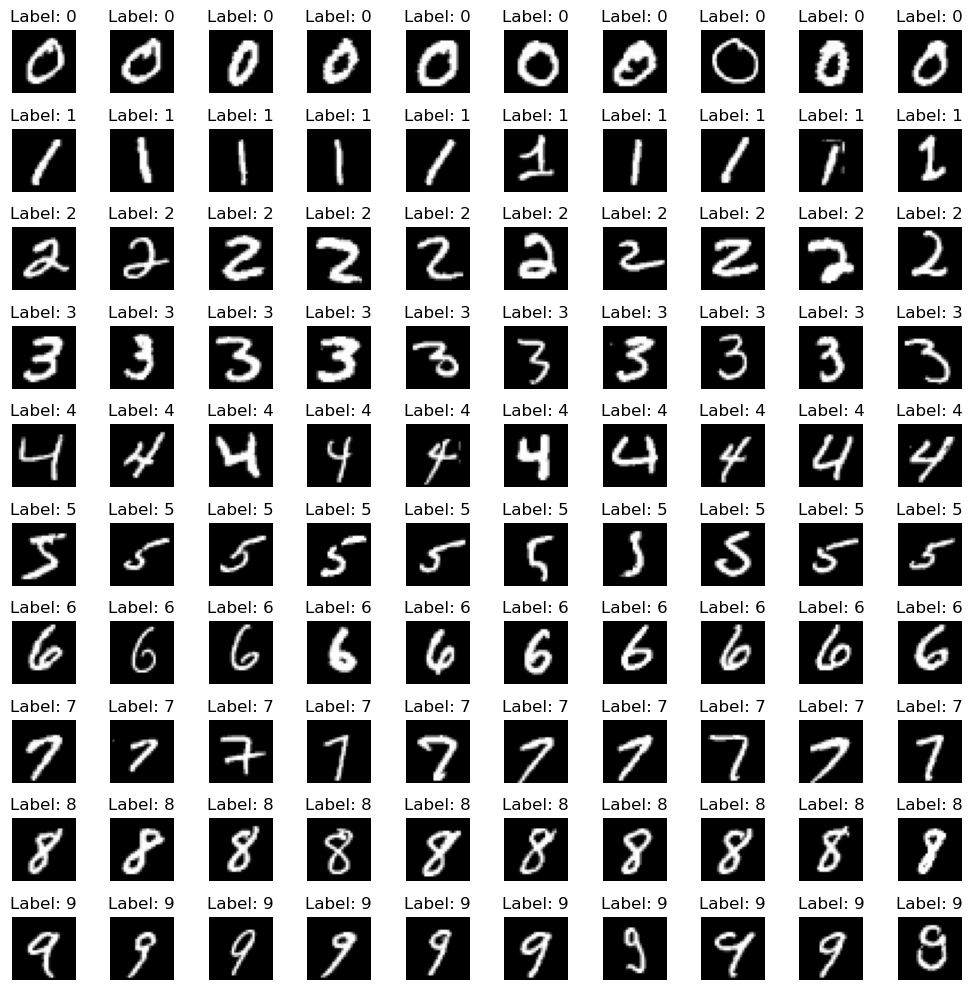

In [9]:
# Visualize 10 examples of each digit
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for digit in range(10):
    digit_indices = np.where(y == digit)[0][:10]  # Get indices of the first 10 examples of the current digit
    for i, index in enumerate(digit_indices):
        ax = axes[digit, i]
        ax.imshow(X[index].reshape(28, 28), cmap='gray')
        ax.set_title(f"Label: {y[index]}")
        ax.axis('off')

plt.tight_layout()
plt.show()

# Creating models and evaluating it on the validation set

# Support Vector Classifier

In [ ]:
# Define the pipeline with MinMaxScaler and PCA
pipeline_svm = Pipeline([
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=0.95)),  # Keep 95% of variance
    ('svm', SVC())
])

# Define the hyperparameter grid for grid search
param_grid = {
    'svm__C': [0.1, 1, 10, 100],  # Regularization parameter
    'svm__kernel': ['linear', 'rbf', 'poly'],  # Kernel function
    'svm__gamma': ['scale', 'auto']  # Gamma parameter
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline_svm, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Evaluate the best model on the validation set
val_accuracy = best_model.score(X_val, y_val)
print("Val Accuracy:", val_accuracy)
print("Best Parameters:", best_params)

In [13]:
# Train an SVM classifier with best predefined hyperparameters
svm_clf = SVC(C=100, kernel='rbf', gamma='scale',probability=True)

# Create the pipeline with MinMaxScaler and PCA
pipeline_svm_clf = Pipeline([
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=0.95)),
    ('svm', svm_clf)
])

# Train an SVM classifier
pipeline_svm_clf.fit(X_train, y_train)

# Evaluate the model on the validation set
svm_clf_accuracy = pipeline_svm_clf.score(X_val, y_val)
print("Val Accuracy:", svm_clf_accuracy)

Val Accuracy: 0.9868


# K Neighbors Classifier

In [ ]:
# Define the parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}

# Initialize k-Nearest Neighbors classifier
knn = KNeighborsClassifier()

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy')

# Perform grid search
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

In [17]:
knn = KNeighborsClassifier(n_neighbors=3, weights='distance', algorithm='auto', p=3)

# Train a KNN classifier
knn.fit(X_train, y_train) 

# Evaluate the model on the validation set
knn_accuracy = knn.score(X_val, y_val)
print("Val Accuracy:", knn_accuracy)

Val Accuracy: 0.9744


# Extra Trees Classifier

In [ ]:
# Define the Extra Trees Classifier
extra_trees_clf = ExtraTreesClassifier(random_state=42)

# Define the hyperparameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2']  # Number of features to consider when looking for the best split
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(extra_trees_clf, param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Evaluate the best model on the validation set
val_accuracy = best_model.score(X_val, y_val)
print("Val Accuracy:", val_accuracy)
print("Best Parameters:", best_params)

In [16]:
# Train an SVM classifier with predefined hyperparameters
extra_trees_clf = ExtraTreesClassifier(n_estimators=200, max_depth=20, min_samples_split=2, min_samples_leaf=1, max_features='sqrt')

# Train a KNN classifier
extra_trees_clf.fit(X_train, y_train) 

# Evaluate the model on the validation set
extra_trees_clf_accuracy = extra_trees_clf.score(X_val, y_val)
print("Val Accuracy:", extra_trees_clf_accuracy)

Val Accuracy: 0.9677


# Model Evaluation on Test Data

In [173]:
# Train best model on train-validation set
pipeline_svm_clf.fit(X_train_val, y_train_val) 

svm_clf_test_pred = pipeline_svm_clf.predict(X_test)

# Evaluate the model on the validation set
svm_clf_test_accuracy = accuracy_score(y_test, svm_clf_test_pred) 

print("Validation Accuracy:", svm_clf_test_accuracy)

Validation Accuracy: 0.9834


In [19]:
# Save the trained SVM classifier model
joblib.dump(pipeline_svm_clf, "svm_clf.pkl")

['svm_clf.pkl']

In [20]:
# Load the saved model
svm_clf_model = joblib.load("svm_clf.pkl")

# Adjusting personal image for prediction

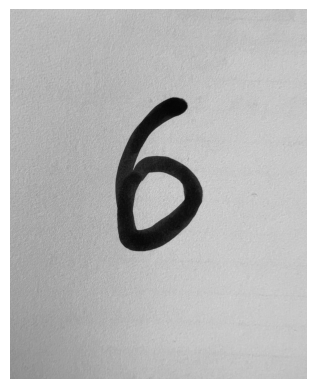

In [156]:
# Load your image in grayscale
image_path = r"C:\Users\46704\Desktop\Data utbildning\Mashine Learning\Kunskapskontroll\siffror for prediction\66.jpg"
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Convert grayscale image to RGB (OpenCV reads images in BGR format)
img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

# Display the image
plt.imshow(img_rgb)
plt.axis('off')  # Hide axis
plt.show()

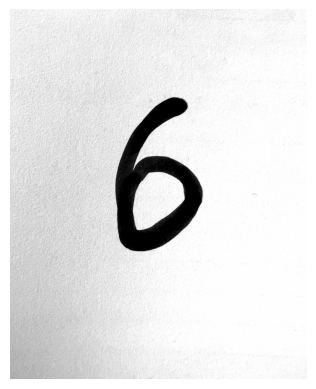

In [157]:
# Increase brightness
brightness_increase = 50
brightened_image = cv2.add(img, brightness_increase)

# Increase contrast
contrast_increase = 1.5
mean_gray = np.mean(brightened_image)
adjusted_image = np.clip((contrast_increase * (brightened_image.astype(np.float32) - mean_gray) + mean_gray), 0, 255).astype(np.uint8)

# Display the original image 
plt.imshow(cv2.cvtColor(adjusted_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

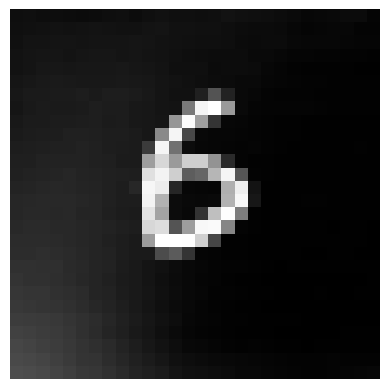

In [158]:
inverted_img = 255 - adjusted_image

# Resize the image to 28x28 pixels
resized_image = cv2.resize(inverted_img, (28, 28), interpolation=cv2.INTER_AREA)

# Display the resized image 
plt.imshow(resized_image, cmap='gray')
plt.axis('off')
plt.show()

In [159]:
# Set print options to display all columns
np.set_printoptions(linewidth=np.inf)

# Display the matrix representation of the first image
print("Matrix representation of the first image:")
print(resized_image)

Matrix representation of the first image:
[[ 14  15  13  13  12  11  12  14  15  12  15  17  15  15  14  15  18  16  15  14  12  10   7   8   9  11  11   5]
 [ 15  16  17  18  17  18  19  18  17  17  19  20  17  17  16  16  14  12  11  11  10   7   5   6   7   7   4   4]
 [ 16  19  19  20  20  19  20  20  20  21  20  18  17  16  15  15  14  11  10  11  11   8   7   7   7   6   5   5]
 [ 18  20  21  21  19  21  22  22  20  21  19  18  16  14  13  12  12  12   9   9   7   5   5   4   4   3   3   2]
 [ 18  20  23  23  22  23  23  23  24  22  21  19  15  15  15  11  12  12  11   7   5   3   2   2   2   2   1   1]
 [ 21  23  25  26  25  24  24  24  25  24  23  20  18  16  14  12  11   9   9   6   5   4   3   3   2   2   2   2]
 [ 23  26  26  27  27  29  26  29  29  27  24  20  17  17  33  83  34   9   7   4   3   3   3   2   2   2   2   2]
 [ 21  25  27  26  26  27  30  28  28  24  23  20  19 122 245 255 154   9   5   4   4   4   4   3   2   2   2   2]
 [ 24  27  27  28  28  29  30  27  28 

In [160]:
# Apply thresholding to preprocess the image
_, thresholded_img = cv2.threshold(resized_image, 127, 255, cv2.THRESH_BINARY)

# Set print options to display all columns
np.set_printoptions(linewidth=np.inf, precision=2)

print("Matrix representation of the image:")
print(thresholded_img)

Matrix representation of the image:
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 255 255 255   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   

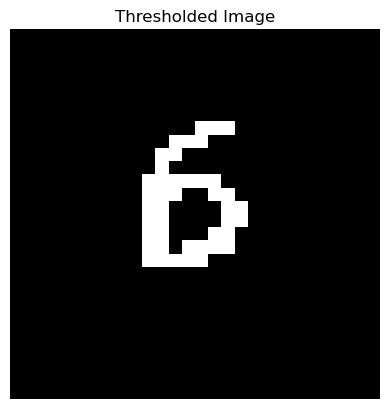

In [161]:
# Visualizing the thresholded image
plt.imshow(thresholded_img, cmap='gray')
plt.axis('off')
plt.title('Thresholded Image')
plt.show()

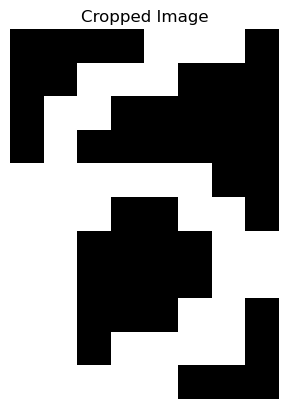

In [162]:
# Applying cropping
while np.sum(thresholded_img[0]) == 0:
    thresholded_img = thresholded_img[1:]
while np.sum(thresholded_img[:,0]) == 0:
    thresholded_img = np.delete(thresholded_img,0,1)
while np.sum(thresholded_img[-1]) == 0:
    thresholded_img = thresholded_img[:-1]
while np.sum(thresholded_img[:,-1]) == 0:
    thresholded_img = np.delete(thresholded_img,-1,1)
rows, cols = thresholded_img.shape

if thresholded_img.size == 0:
    print("After cropping, the image turned out to be empty")
else:
    rows, cols = thresholded_img.shape

# Visualizing the cropped image
plt.imshow(thresholded_img, cmap='gray')
plt.axis('off')
plt.title('Cropped Image')
plt.show()

In [163]:
# Set print options to display all columns
np.set_printoptions(linewidth=np.inf, precision=2)

print("Matrix representation of the image (all 28 columns in the same row with 2 decimal places):")
print(thresholded_img)

Matrix representation of the image (all 28 columns in the same row with 2 decimal places):
[[  0   0   0   0 255 255 255   0]
 [  0   0 255 255 255   0   0   0]
 [  0 255 255   0   0   0   0   0]
 [  0 255   0   0   0   0   0   0]
 [255 255 255 255 255 255   0   0]
 [255 255 255   0   0 255 255   0]
 [255 255   0   0   0   0 255 255]
 [255 255   0   0   0   0 255 255]
 [255 255   0   0   0 255 255   0]
 [255 255   0 255 255 255 255   0]
 [255 255 255 255 255   0   0   0]]


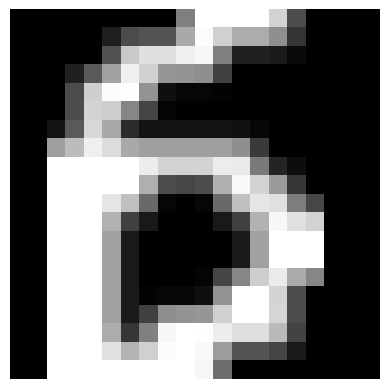

In [164]:
# Resize the image to fit within a 20x20 pixel box
if rows > cols:
    factor = 20.0 / rows
    rows = 20
    cols = int(round(cols * factor))
    thresholded_shifted = cv2.resize(thresholded_img, (cols, rows))
else:
    factor = 20.0 / cols
    cols = 20
    rows = int(round(rows * factor))
    thresholded_shifted = cv2.resize(thresholded_img, (cols, rows))

# Create a new image with dimensions of 20x20 pixels
new_image = np.zeros((20, 20))

# Copy the modified image to the center of the new image
row_offset = (20 - rows) // 2
col_offset = (20 - cols) // 2
new_image[row_offset:row_offset + rows, col_offset:col_offset + cols] = thresholded_shifted

# Displaying the 20x20 pixel image
plt.imshow(new_image, cmap='gray')
plt.axis('off')
plt.show()

In [165]:
# Set print options to display all columns
np.set_printoptions(linewidth=np.inf)

print("Matrix representation of the image (all 28 columns in the same row with 2 decimal places):")
print(new_image)

Matrix representation of the image (all 28 columns in the same row with 2 decimal places):
[[  0.   0.   0.   0.   0.   0.   0.   0.   0. 127. 255. 255. 255. 255. 212.  76.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.  30.  75.  83.  83. 169. 252. 208. 172. 172. 143.  52.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.  82. 201. 223. 223. 239. 247. 128.  32.  32.  27.  10.   0.   0.   0.   0.]
 [  0.   0.   0.  32.  90. 162. 240. 208. 150. 147. 142.  64.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.  75. 207. 251. 254. 147.  15.   6.   6.   3.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.  76. 212. 206. 134.  69.   4.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.  19.  90. 216. 168.  43.  19.  19.  19.  19.  19.  17.   7.   0.   0.   0.   0.   0.   0.]
 [  0.   0. 159. 188. 239. 220. 169. 159. 159. 159. 159. 159. 143.  58.   0.   0.   0.   0.   0.   0.]
 [  0.   0. 255. 255. 255. 255. 255. 236. 212. 210. 212. 236. 234. 122.  37.  13.   0

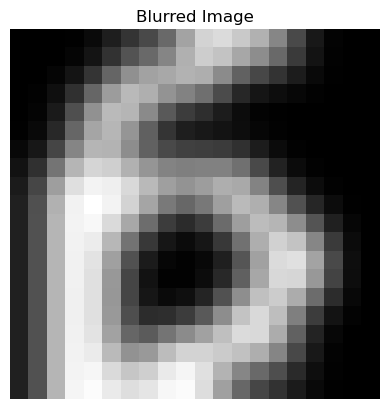

In [166]:
# Applying Gaussian Blur
blurred = cv2.GaussianBlur(new_image, (5, 5), 0)

rows, cols = blurred.shape

if blurred.size == 0:
    print("After cropping, the image turned out to be empty")
else:
    rows, cols = blurred.shape

# Displaying blurred imageе
plt.imshow(blurred, cmap='gray')
plt.axis('off')
plt.title('Blurred Image')
plt.show()

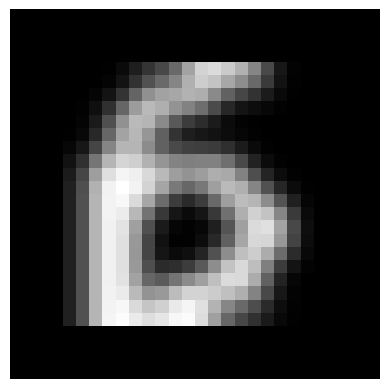

In [167]:
# Creating a new image with dimensions of 28x28 pixels
final_image = np.zeros((28, 28), dtype=np.uint8)

# Calculate offsets to place the 20x20 image in the center of the 28x28 image
row_offset = (28 - 20) // 2
col_offset = (28 - 20) // 2

# Copy the 20x20 image into the center of the 28x28 image
final_image[row_offset:row_offset + 20, col_offset:col_offset + 20] = blurred

# Display the final image
plt.imshow(final_image, cmap='gray')
plt.axis('off')
plt.show()

In [168]:
# Set print options to display all columns
np.set_printoptions(linewidth=np.inf)

# Display the scaled image
print("Final image:")
print(final_image)

Final image:
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   1  10  29  51  70 103 159 205 212 195 171 129  71  23   3   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   4  19  49  80 102 129 170 198 189 162 137 102  56  18   2   0   0   0   0   0   0]
 [  0   0   0   0   0   0   5  19  50  97 139 157 162 172 168 134  94  68  49  27   9   1   0   0   0   0   0   0]
 [  0   0   0   0   0   2  15  47  99 151 179 169 143 126 107  73  38  20  13   7   2   0   0   0   0   0   0   0]
 [  0   0   0   0   0   4  26  77 140 180 175 134  87  59  44  27  

In [169]:
# Defining a function to calculate the best shift for centering the image
def getBestShift(final_image):
    cy,cx = center_of_mass(final_image)
    
    rows,cols = final_image.shape
    shiftx = np.round(cols/2.0-cx).astype(int)
    shifty = np.round(rows/2.0-cy).astype(int)

    return shiftx,shifty

# Defining a function to shift the image
def shift(final_image,sx,sy):
    rows,cols = final_image.shape
    M = np.float32([[1,0,sx],[0,1,sy]])
    shifted = cv2.warpAffine(final_image,M,(cols,rows))
    return shifted


# Getting the necessary shifts for centering the object
shiftx, shifty = getBestShift(final_image)

# Shifting the image
shifted = shift(final_image, shiftx, shifty)

# Printing the matrix representation of the shifted image
print("Matrix representation of the shifted image (all 28 columns in the same row with 2 decimal places):")
print(shifted)

Matrix representation of the shifted image (all 28 columns in the same row with 2 decimal places):
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   1  10  29  51  70 103 159 205 212 195 171 129  71  23   3   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   4  19  49  80 102 129 170 198 189 162 137 102  56  18   2   0   0   0   0]
 [  0   0   0   0   0   0   0   0   5  19  50  97 139 157 162 172 168 134  94  68  49  27   9   1   0   0   0   0]
 [  0   0   0   0   0   0   0   2  15  47  99 151 179 169 143 126 107  73  38  20  13   7   2   0   0   0   0   0]
 [  0   0   0   0   0   0   0   4  26  77 140 180 175 134  87  59  44  27  11   3   1   0   0   

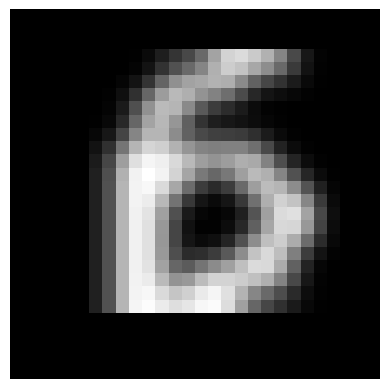

In [170]:
# Display the final image
plt.imshow(shifted, cmap='gray')
plt.axis('off')
plt.show()

In [171]:
img_flat = shifted.reshape(1, -1)

# Make prediction using the loaded SVM model
prediction = pipeline_svm_clf.predict(img_flat)
print("Predicted Class:", prediction[0])

Predicted Class: 6


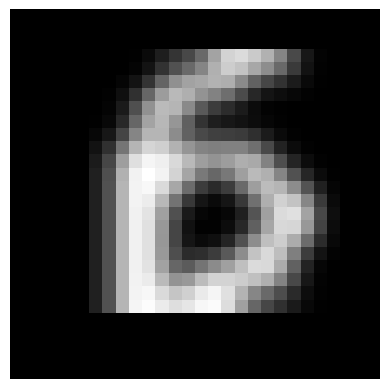

Predicted Class: 6


In [172]:
# Display the final image
plt.imshow(shifted, cmap='gray')
plt.axis('off')
plt.show()

print("Predicted Class:", prediction[0])